# GeMusic

Hear the stochastic energy depositions in a Ge crystal.  Map germanium time series data to MIDI sound.

This can be used to trigger audio samples, etc.  

A few ideas:

* Map an energy variable to MIDI sound inputs.   Can you hear more frequent occurences such as peaks?

* Work with roughly calibrated energy.

* Map of energy to frequency:  Can be proportional (E = h f), or can try things like E = h / f so that higher energies make deep and echoing sounds

* Gate on known peaks to hear intervals/ratios between peaks.

* What if peak events did a chord?  

* Give it an ending.  Maybe let it ring out on one of the high energy events.

Stretch goals: 

* Generate custom synthesizer tones (sine, saw, square, etc) based on Ge pulse shape parameters

* pyqtgraph widget:  interactive energy spectrum, adjusting gates, eq, etc in real time.  Can we embed those widgets in an ipython notebook?

* Send MIDI output file to Garageband -- how "creative" can I make these sounds?  In addition to spacey synth sounds, what if they triggered DRUM samples?  Chaosss

* Real-time monitoring: Connect to oscilloscope or ORCARoot to hear data taken live from the UW teststands

References: 
* [How to convert data into music with python](https://medium.com/@astromattrusso/sonification-101-how-to-convert-data-into-music-with-python-71a6dd67751c)
* [Build your own python synthesizer](https://python.plainenglish.io/making-a-synth-with-python-oscillators-2cb8e68e9c3b)

In [1]:
import numpy as np
import pandas as pd
import h5py
import math
import itertools
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa

# to work with python3.10, install this directly from github
# pip install git+https://github.com/danilobellini/audiolazy.git
from audiolazy import str2midi, midi2str

from midiutil import MIDIFile
import pygame
import pyaudio # requires `brew install portaudio`

# import oscillators as osc # local file, oscillators.py
import oscillators as osc

pygame 2.1.2 (SDL 2.0.18, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Generating MIDI from Ge waveform parameters

Take a Ge file and map the energy (and/or various other DSP parameters) to the MIDI standard, where each note has a frequency/volume pair.

The default MIDI output is just a sample piano, which is a little "blah," but good for demonstration.

In [3]:
# import energies & timestamps from a file for now.

# f_in = '/Users/wisecg/Data/LH5/cage/dsp/cage_run244_cyc1969_dsp.lh5'
f_in = './ge_data/cage_run244_cyc1969_dsp.lh5'

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
f = h5py.File(f_in,'r')
# f.visititems(print_attrs)

e_key = 'ORSIS3302DecoderForEnergy/dsp/energy'
# a_key = 'ORSIS3302DecoderForEnergy/dsp/AoE' # idea - map multiple variables for more complicated sounds
t_key = 'ORSIS3302DecoderForEnergy/dsp/timestamp'

# n_evts = 1000
# ge_energy = f[e_key][:n_evts]
# ge_tstamp = f[t_key][:n_evts]

ge_energy = f[e_key][...]
ge_tstamp = f[t_key][...]

f.close()

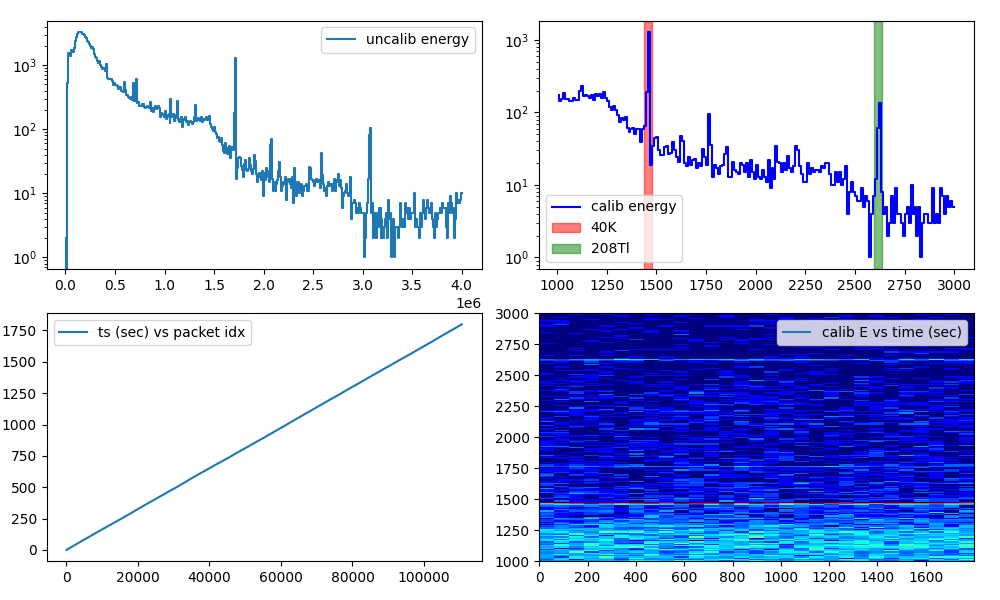

In [4]:
# quick diagnostic plots for data integrity
%matplotlib widget

fig, p = plt.subplots(2, 2, figsize=(10, 6))
fig.canvas.header_visible = False
plt.tight_layout()

# uncalibrated energy histogram
xlo, xhi, xpb = 0, 4e6, 10000
nbins = int((xhi-xlo)/xpb)
hist, bins = np.histogram(ge_energy, nbins, range=(xlo, xhi))
# bins includes left edge of first bin and right edge of all other bins.
p[0,0].semilogy(bins[1:], hist, ds='steps', label='uncalib energy')
p[0,0].legend()

# calibrated energy histogram
ecal_const = 1.71e6 # simplest
ge_enecal = ge_energy * (1460 / ecal_const)

elo, ehi, epb = 1000, 3000, 10
nbins = int((ehi-elo)/epb)
hist, bins = np.histogram(ge_enecal, bins=nbins, range=(elo, ehi))
p[0,1].semilogy(bins[1:], hist, ds='steps', c='b', label='calib energy')

width = 20 # keV
p[0,1].axvspan(1460 - width, 1460 + width, alpha=0.5, color='red', label='40K')
p[0,1].axvspan(2615 - width, 2615 + width, alpha=0.5, color='green', label='208Tl')
p[0,1].legend(loc=3)

# timestamp vs packet index
clock_freq = 100e6 # MHz
ts_sec = (ge_tstamp - ge_tstamp[0]) / clock_freq # seconds
p[1,0].plot(np.arange(len(ts_sec)), ts_sec, label='ts (sec) vs packet idx')
p[1,0].legend()

# 2d hist, calibrated energy vs time, 30 sec bins 
# p[1,1].scatter(ts_sec, ge_enecal) # scatter is too busy-looking
from matplotlib.colors import PowerNorm # map colors onto y = x ^ gamma, for fun.
tlo, thi, tpb = 0, np.max(ts_sec), 60 # 30 sec bins
nbins_e = int((ehi-elo)/epb)
nbins_t = int((thi-tlo)/tpb)
ix = np.where((ge_enecal > elo) & (ge_enecal < ehi))
e_h2d, ex, ey = np.histogram2d(ts_sec[ix], ge_enecal[ix], bins=[nbins_t, nbins_e],
                                 range=[[tlo, thi], [elo, ehi]])
x, y = np.meshgrid(ex, ey)
cm = p[1,1].pcolormesh(x, y, e_h2d.T, cmap='jet', norm=PowerNorm(gamma=0.5))#, vmin=0.1, vmax=np.max(e_h2d))
# plt.colorbar(cm, ax=p[1,1])
p[1,1].plot(np.nan, label='calib E vs time (sec)')
p[1,1].legend(loc=1)


plt.show()

In [5]:
# now I have times (in seconds) and energy (in keV).  
# Do a very simple map to MIDI - note & loudness. 

# for fun, select out only events from the two peaks, to map to two tones.
ix_2tone = np.where((ge_enecal > 1460 - width) & (ge_enecal < 1460 + width) | 
                    (ge_enecal > 2615 - width) & (ge_enecal < 2615 + width))
en_2tone = ge_enecal[ix_2tone]
ts_2tone = ts_sec[ix_2tone]
print(len(en_2tone), en_2tone, ts_2tone)

def map_value(value, min_value, max_value, min_result, max_result):
    """maps value (or array of values) from one range to another"""
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

e_min, e_max = np.min(ge_enecal), np.max(ge_enecal)
t_min, t_max = np.min(ge_tstamp), np.max(ge_tstamp)

# to map to MIDI, it's convenient to normalize the input data between [0, 1]
y_data = map_value(en_2tone, elo, ehi, 0, 1)

note_names = ['C2','D2','E2','G2','A2',
             'C3','D3','E3','G3','A3',
             'C4','D4','E4','G4','A4'] # major pentatonic

note_midis = [str2midi(n) for n in note_names]

# assign pitch (midi note)
midi_data = []
for i in range(len(y_data)):
    note_index = round(map_value(y_data[i], 0, 1, len(note_names)-1, 0)) 
    midi_data.append(note_midis[note_index])
midi_data = np.asarray(midi_data)

# assign velocity (loudness)
vel_min,vel_max = 35, 127   # minimum and maximum note velocity
vel_data = []
for i in range(len(y_data)):
    note_velocity = round(map_value(y_data[i],0,1,vel_min, vel_max)) 
    vel_data.append(note_velocity)
vel_data = np.asarray(vel_data)

1787 [1463.29140351 1462.48797661 1463.42545029 ... 1462.87218713 1467.34183626
 1462.18060819] [7.93839190e-01 5.27631285e+00 7.00964380e+00 ... 1.79682982e+03
 1.79807462e+03 1.79854085e+03]


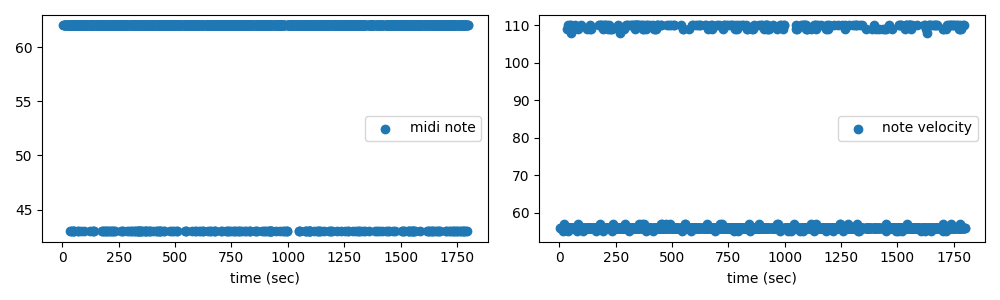

In [6]:
%matplotlib widget
fig, p = plt.subplots(1, 2, figsize=(10,3))
fig.canvas.header_visible = False

p[0].scatter(ts_2tone, np.array(midi_data), label='midi note')
p[0].set_xlabel('time (sec)')
p[0].legend()

p[1].scatter(ts_2tone, vel_data, label='note velocity')
p[1].set_xlabel('time (sec)')
p[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# create midi file object
my_midi_file = MIDIFile(1) # one track 
bpm = 60
my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

# add midi notes
for i in range(len(ts_2tone)):
    my_midi_file.addNote(track=0, channel=0, time = ts_2tone[i], 
                         pitch = midi_data[i], volume = vel_data[i], 
                         duration = 2)

# create and save the midi file
with open('./midi/ge_2tone.mid', 'wb') as f:
    my_midi_file.writeFile(f)

In [8]:
# play the simple midi file with pygame
""" 
Note from Russo's essay:
Once you drag the MIDI file onto a new track in a DAW, you can choose an instrument sound 
from the DAW's library. You can also change the tempo, add effects, or add completely new 
layers to complete your musical world.
"""
pygame.init()
pygame.mixer.music.load('./midi/ge_2tone.mid')
pygame.mixer.music.play()

In [9]:
pygame.mixer.music.stop()

[36, 38, 40, 43, 45, 48, 50, 52, 55, 57, 60, 62, 64, 67, 69]


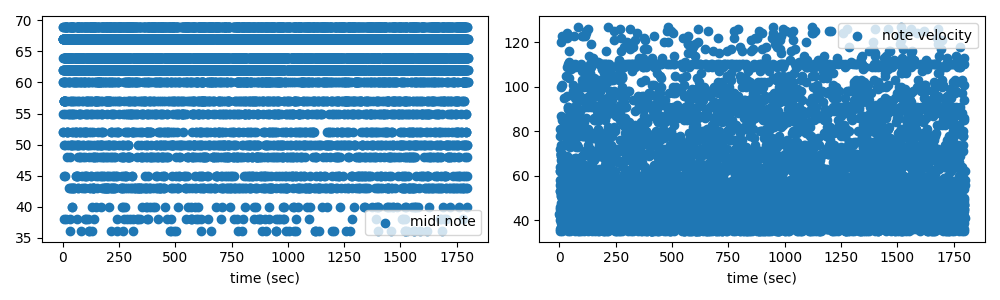

In [11]:
# take a different selection and export to MIDI file

# ix_tones = np.where((ge_enecal > 1460 - width) & (ge_enecal < 1460 + width) | 
#                     (ge_enecal > 2615 - width) & (ge_enecal < 2615 + width))

ix_tones = np.where((ge_enecal > 1000) & (ge_enecal < 3000))

en_tone = ge_enecal[ix_tones]
ts_tone = ts_sec[ix_tones]

e_min, e_max = np.min(ge_enecal), np.max(ge_enecal)
t_min, t_max = np.min(ge_tstamp), np.max(ge_tstamp)

# to map to MIDI, it's convenient to normalize the input data between [0, 1]
y_data = map_value(en_tone, elo, ehi, 0, 1)

note_names = ['C2','D2','E2','G2','A2',
             'C3','D3','E3','G3','A3',
             'C4','D4','E4','G4','A4'] # major pentatonic

note_midis = [str2midi(n) for n in note_names]

print(note_midis)

# assign pitch (midi note)
midi_data = []
for i in range(len(y_data)):
    note_index = round(map_value(y_data[i], 0, 1, len(note_names)-1, 0)) 
    midi_data.append(note_midis[note_index])
midi_data = np.asarray(midi_data)

# assign velocity (loudness)
vel_min,vel_max = 35, 127   # minimum and maximum note velocity
vel_data = []
for i in range(len(y_data)):
    note_velocity = round(map_value(y_data[i],0,1,vel_min, vel_max)) 
    vel_data.append(note_velocity)
vel_data = np.asarray(vel_data)

# create midi file object
my_midi_file = MIDIFile(1) # one track 
bpm = 60
my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

# add midi notes
for i in range(len(ts_tone)):
    my_midi_file.addNote(track=0, channel=0, time = ts_tone[i], 
                         pitch = midi_data[i], volume = vel_data[i], 
                         duration = 2)

# create and save the midi file
with open('./midi/ge_1k3ktones.mid', 'wb') as f:
    my_midi_file.writeFile(f)

%matplotlib widget
fig, p = plt.subplots(1, 2, figsize=(10,3))
fig.canvas.header_visible = False

p[0].scatter(ts_tone, np.array(midi_data), label='midi note')
p[0].set_xlabel('time (sec)')
p[0].legend()

p[1].scatter(ts_tone, vel_data, label='note velocity')
p[1].set_xlabel('time (sec)')
p[1].legend()

plt.tight_layout()
plt.show()

In [12]:
pygame.init()
pygame.mixer.music.load('./midi/ge_1k3ktones.mid')
pygame.mixer.music.play()

In [13]:
pygame.mixer.music.stop()